In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os

In [2]:
tracking2018 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2018.csv")
tracking2019 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2019.csv")
tracking2020 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2020.csv")

tracking2018.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right


In [3]:
play_data = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/plays.csv")
returned_plays = play_data.query("specialTeamsResult == 'Return' and passResult.isnull() and penaltyYards.isnull() and (not returnerId.isnull())", engine='python', inplace=False)


In [4]:
teammate_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/teammate_dataset.pkl')
opponent_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/opponent_dataset.pkl')

In [5]:
time_s = teammate_df.loc[0,'time']

In [6]:
display(teammate_df.query("playId == 677 and time == @time_s"))

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
0,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,42515.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[32.17, 38.71, 0.34, 3.44, 3.64, 78.81, 341.2...","[[32.07, 39.05, 0.35, 3.57, 3.48, 76.56, 346.4...",[-0.09],"[[0.1, -0.34, -0.01, -0.13, 0.16, 2.25, -5.16,...","[[-0.21, -0.11, -0.01, -0.16, -0.2, 2.99, -10...."
1,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,43442.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[21.67, 43.81, 0.23, 2.35, 3.25, 145.89, 56.5...","[[21.88, 43.92, 0.24, 2.51, 3.45, 142.9, 67.26...",[-0.09],"[[-0.21, -0.11, -0.01, -0.16, -0.2, 2.99, -10....","[[0.39, -0.34, 0.02, 0.29, -0.37, 0.0, -4.31, ..."
2,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,43497.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[34.23, 31.98, 0.54, 5.36, 3.09, 83.47, 308.5...","[[33.84, 32.32, 0.52, 5.07, 3.46, 83.47, 312.8...",[-0.09],"[[0.39, -0.34, 0.02, 0.29, -0.37, 0.0, -4.31, ...","[[0.21, -0.35, 0.0, -0.07, 0.21, -2.28, -3.53,..."
3,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,46118.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[33.75, 35.52, 0.4, 3.96, 2.34, 52.95, 327.5,...","[[33.54, 35.87, 0.4, 4.03, 2.13, 55.23, 331.03...",[-0.09],"[[0.21, -0.35, 0.0, -0.07, 0.21, -2.28, -3.53,...","[[-0.36, -0.36, 0.0, 0.02, -0.51, -6.83, -8.95..."
4,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,45599.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[20.92, 38.29, 0.52, 5.16, 5.24, 60.63, 39.12...","[[21.28, 38.65, 0.52, 5.14, 5.75, 67.46, 48.07...",[-0.09],"[[-0.36, -0.36, 0.0, 0.02, -0.51, -6.83, -8.95...","[[0.42, -0.24, 0.01, 0.09, -0.09, -3.73, 2.71,..."
5,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,46194.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[39.08, 24.57, 0.5, 4.94, 2.01, 122.56, 301.0...","[[38.66, 24.81, 0.49, 4.85, 2.1, 126.29, 298.3...",[-0.09],"[[0.42, -0.24, 0.01, 0.09, -0.09, -3.73, 2.71,...","[[0.08, -0.26, -0.01, -0.05, 0.15, -1.26, -3.5..."
6,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,40408.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[39.07, 41.27, 0.25, 2.59, 1.39, 99.09, 341.4...","[[38.99, 41.53, 0.26, 2.64, 1.24, 100.35, 344....",[-0.09],"[[0.08, -0.26, -0.01, -0.05, 0.15, -1.26, -3.5...","[[0.07, 0.11, -0.02, -0.17, 0.38, -0.69, 8.82,..."
7,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,44911.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[39.83, 44.49, 0.11, 1.13, 2.56, 97.59, 217.0...","[[39.76, 44.38, 0.13, 1.3, 2.18, 98.28, 208.2,...",[-0.09],"[[0.07, 0.11, -0.02, -0.17, 0.38, -0.69, 8.82,...","[[0.08, -0.38, -0.04, -0.33, 0.6, -2.47, -3.17..."


In [7]:
display(opponent_df.query("playId == 677 and time == @time_s"))

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
0,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,38707.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[44.11, 24.92, 1.01, 10.05, 0.76, 299.74, 292...","[[43.17, 25.29, 1.01, 10.09, 0.75, 296.5, 291....",[-0.09],"[[0.94, -0.37, 0.0, -0.04, 0.01, 3.24, 0.45, 0...","[[0.87, -0.3, -0.01, -0.04, -0.05, -1.93, 1.07..."
1,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,40191.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[43.9, 21.75, 0.91, 9.11, 1.06, 283.77, 289.8...","[[43.03, 22.05, 0.92, 9.15, 1.11, 285.7, 288.8...",[-0.09],"[[0.87, -0.3, -0.01, -0.04, -0.05, -1.93, 1.07...","[[0.92, -0.01, -0.01, 0.01, -0.1, 0.0, -0.08, ..."
2,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,42450.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[45.07, 49.79, 0.91, 9.18, 0.44, 251.62, 270....","[[44.15, 49.8, 0.92, 9.17, 0.54, 251.62, 270.1...",[-0.09],"[[0.92, -0.01, -0.01, 0.01, -0.1, 0.0, -0.08, ...","[[0.69, -0.08, 0.0, 0.03, 0.05, -0.69, 0.69, 0..."
3,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,43306.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[50.5, 46.24, 0.7, 7.0, 1.05, 275.39, 277.13,...","[[49.81, 46.32, 0.7, 6.97, 1.0, 276.08, 276.44...",[-0.09],"[[0.69, -0.08, 0.0, 0.03, 0.05, -0.69, 0.69, 0...","[[0.85, -0.29, 0.01, 0.12, -0.08, 2.19, -0.11,..."
4,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,46263.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[41.11, 32.25, 0.91, 9.01, 1.72, 292.28, 288....","[[40.26, 32.54, 0.9, 8.89, 1.8, 290.09, 288.69...",[-0.09],"[[0.85, -0.29, 0.01, 0.12, -0.08, 2.19, -0.11,...","[[0.85, -0.29, 0.01, 0.05, -0.18, -3.12, -1.75..."
5,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,46269.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[43.08, 38.77, 0.91, 8.97, 2.14, 279.98, 287....","[[42.23, 39.06, 0.9, 8.92, 2.32, 283.1, 289.04...",[-0.09],"[[0.85, -0.29, 0.01, 0.05, -0.18, -3.12, -1.75...","[[0.66, -0.16, 0.0, 0.1, -0.19, 0.0, 0.54, 0.6..."
6,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,37267.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[53.07, 37.21, 0.68, 6.8, 1.15, 293.27, 284.2...","[[52.41, 37.37, 0.68, 6.7, 1.34, 293.27, 283.6...",[-0.09],"[[0.66, -0.16, 0.0, 0.1, -0.19, 0.0, 0.54, 0.6...","[[0.82, -0.37, 0.01, 0.09, -0.13, 3.12, -0.89,..."
7,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,44887.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[43.95, 27.63, 0.9, 8.96, 1.64, 286.85, 293.3...","[[43.13, 28.0, 0.89, 8.87, 1.77, 283.73, 294.2...",[-0.09],"[[0.82, -0.37, 0.01, 0.09, -0.13, 3.12, -0.89,...","[[0.91, -0.18, 0.01, 0.09, -0.2, 1.81, -1.09, ..."
8,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,44962.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[40.75, 33.99, 0.94, 9.31, 1.89, 281.5, 280.2...","[[39.84, 34.17, 0.93, 9.22, 2.09, 279.69, 281....",[-0.09],"[[0.91, -0.18, 0.01, 0.09, -0.2, 1.81, -1.09, ...","[[0.86, -0.13, 0.02, 0.28, -0.47, -2.86, -0.47..."
9,2018,2018090600,677,0,52,2018-09-07T01:34:34.500,44987.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[44.18, 42.04, 0.9, 8.92, 2.05, 286.72, 278.3...","[[43.32, 42.17, 0.88, 8.64, 2.52, 289.58, 278....",[-0.09],"[[0.86, -0.13, 0.02, 0.28, -0.47, -2.86, -0.47...","[[0.94, -0.37, 0.0, 0.0, -0.09, 0.0, 0.33, 0.9..."


In [8]:
data_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/teammate_dataset.pkl')

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


/home/amans/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


In [10]:
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data_df, 0.7, 2430)


In [11]:
display(test_data.head())

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
68983,2018,2018092303,2350,193,87,2018-09-23T18:51:17.700,41984.0,"[[100.39, 27.08, 0.62, 6.75, 4.09, 0.0, 0.0, 1...","[[95.87, 29.9, 0.58, 5.85, 2.4, 23.72, 27.94, ...","[[96.17, 30.41, 0.59, 5.89, 2.66, 35.61, 31.59...",[-80.46],"[[-0.3, -0.51, -0.01, -0.04, -0.26, -11.89, -3...","[[-0.31, -0.51, -0.01, -0.09, 0.13, 5.8, 5.18,..."
104283,2018,2018093008,36,302,69,2018-09-30T20:05:31.700,45352.0,"[[97.58, 27.06, 0.77, 7.42, 2.89, 0.0, 0.0, 22...","[[87.18, 25.79, 0.21, 2.2, 3.09, 308.18, 149.3...","[[87.28, 25.57, 0.24, 2.49, 3.09, 304.33, 156....",[-74.73],"[[-0.1, 0.22, -0.03, -0.29, 0.0, 3.85, -7.12, ...","[[-0.06, 0.26, 0.0, 0.06, -0.21, 5.67, -3.48, ..."
106337,2018,2018093008,2376,307,99,2018-09-30T21:52:49.600,42592.0,"[[86.47, 38.89, 0.01, 0.37, 4.21, 0.0, 0.0, 33...","[[72.61, 23.41, 0.48, 4.85, 2.82, 9.35, 7.5, 4...","[[72.7, 23.89, 0.49, 4.92, 2.89, 10.68, 11.59,...",[-52.94],"[[-0.09, -0.48, -0.01, -0.07, -0.07, -1.33, -4...","[[0.31, -0.04, 0.02, 0.22, 0.38, 16.62, 0.34, ..."
63199,2018,2018092300,4151,175,77,2018-09-23T20:10:49.700,44969.0,"[[26.75, 13.04, 0.81, 8.07, 2.96, 0.0, 0.0, 26...","[[29.35, 12.83, 0.26, 2.56, 2.34, 95.48, 100.9...","[[29.6, 12.77, 0.26, 2.55, 2.01, 92.09, 105.92...",[-0.73],"[[-0.25, 0.06, 0.0, 0.01, 0.33, 3.39, -5.01, -...","[[-0.16, 0.14, 0.01, 0.21, 0.16, -2.02, 0.84, ..."
7887,2018,2018090901,4136,20,86,2018-09-09T20:07:07.800,42373.0,"[[42.02, 36.73, 0.35, 3.54, 1.33, 0.0, 0.0, 42...","[[43.5, 34.27, 0.58, 6.06, 4.19, 349.37, 281.1...","[[43.06, 34.34, 0.44, 5.46, 4.15, 312.97, 277....",[-0.41],"[[0.44, -0.07, 0.14, 0.6, 0.04, 36.4, 3.48, 0....","[[0.61, -0.22, 0.0, 0.04, 0.49, 0.59, 0.58, 0...."


In [12]:
'''
Function that adds needed features to the play df


pd.options.mode.chained_assignment = None

def modify_play_df(play_df):
    # shift x-axis based on target's endzone
    playDirection = play_df.loc[play_df.index[0],'playDirection']
    
    if playDirection == 'left':
        play_df['adj_x'] = play_df['x']
        play_df['adj_y'] = play_df['y'] - 26.65
        # change dir and rotation
        play_df['adj_o'] = (play_df['o'] + 270) % 360
        play_df['adj_dir'] = (play_df['dir'] + 270) % 360
    if playDirection == 'right':
        play_df['adj_x'] = 120 - play_df['x']
        play_df['adj_y'] = play_df['y'] - 26.65
        # change dir and rotation
        play_df['adj_o'] = (play_df['o'] + 90) % 360
        play_df['adj_dir'] = (play_df['dir'] + 90) % 360
        
        
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'o'] = 0
    play_df.loc[play_df.team == 'football', 'dir'] = 0
    play_df.loc[play_df.team == 'football', 'adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'adj_dir'] = 0
    
    play_df['adj_o'].round(2)
    play_df['adj_dir'].round(2)
    
    play_df['sin_adj_o'] = np.sin(play_df['adj_o'])
    play_df['cos_adj_o'] = np.cos(play_df['adj_o'])
    play_df['sin_adj_dir'] = np.sin(play_df['adj_dir'])
    play_df['cos_adj_dir'] = np.cos(play_df['adj_dir'])
    
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'cos_adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'cos_adj_dir'] = 0
    
    
    play_df.loc[:, 'next_x'] = play_df.groupby('displayName').x.shift(-1)
    play_df.loc[:, 'next_y'] = play_df.groupby('displayName').y.shift(-1)
    play_df.loc[:, 'next_dis'] = play_df.groupby('displayName').dis.shift(-1)
    play_df.loc[:, 'next_s'] = play_df.groupby('displayName').s.shift(-1)
    play_df.loc[:, 'next_a'] = play_df.groupby('displayName').a.shift(-1)
    play_df.loc[:, 'next_o'] = play_df.groupby('displayName').o.shift(-1)
    play_df.loc[:, 'next_dir'] = play_df.groupby('displayName').dir.shift(-1)
    play_df.loc[:, 'next_adj_x'] = play_df.groupby('displayName').adj_x.shift(-1)
    play_df.loc[:, 'next_adj_y'] = play_df.groupby('displayName').adj_y.shift(-1)
    play_df.loc[:, 'next_adj_o'] = play_df.groupby('displayName').adj_o.shift(-1)
    play_df.loc[:, 'next_adj_dir'] = play_df.groupby('displayName').adj_dir.shift(-1)
    play_df.loc[:, 'next_sin_adj_o'] = play_df.groupby('displayName').sin_adj_o.shift(-1)
    play_df.loc[:, 'next_cos_adj_o'] = play_df.groupby('displayName').cos_adj_o.shift(-1)
    play_df.loc[:, 'next_sin_adj_dir'] = play_df.groupby('displayName').sin_adj_dir.shift(-1)
    play_df.loc[:, 'next_cos_adj_dir'] = play_df.groupby('displayName').cos_adj_dir.shift(-1)
    
    # remove NAs created by shifting; i.e. remove plays where there is no next play
    play_df.dropna(axis=0, how='any', subset=['x'], inplace=True)
    
    return play_df
'''


def modify_play_df(play_df):
    # shift x-axis based on target's endzone
    playDirection = play_df.loc[play_df.index[0],'playDirection']
    
    if playDirection == 'left':
        play_df.insert(len(play_df.columns),'adj_x', play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 270) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 270) % 360)
    if playDirection == 'right':
        
        play_df.insert(len(play_df.columns),'adj_x', 120 - play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 90) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 90) % 360)
        
        
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'o'] = 0
    play_df.loc[play_df.team == 'football', 'dir'] = 0
    play_df.loc[play_df.team == 'football', 'adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'adj_dir'] = 0
    
    play_df['adj_o'].round(2)
    play_df['adj_dir'].round(2)
    
    play_df.insert(len(play_df.columns), 'sin_adj_o', np.sin(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'cos_adj_o', np.cos(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'sin_adj_dir', np.sin(play_df.loc[:,'adj_dir']))
    play_df.insert(len(play_df.columns), 'cos_adj_dir', np.cos(play_df.loc[:,'adj_dir']))
    
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'cos_adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'cos_adj_dir'] = 0
    
    
    play_df.loc[:, 'next_x'] = play_df.groupby('displayName').x.shift(-1)
    play_df.loc[:, 'next_y'] = play_df.groupby('displayName').y.shift(-1)
    play_df.loc[:, 'next_dis'] = play_df.groupby('displayName').dis.shift(-1)
    play_df.loc[:, 'next_s'] = play_df.groupby('displayName').s.shift(-1)
    play_df.loc[:, 'next_a'] = play_df.groupby('displayName').a.shift(-1)
    play_df.loc[:, 'next_o'] = play_df.groupby('displayName').o.shift(-1)
    play_df.loc[:, 'next_dir'] = play_df.groupby('displayName').dir.shift(-1)
    play_df.loc[:, 'next_adj_x'] = play_df.groupby('displayName').adj_x.shift(-1)
    play_df.loc[:, 'next_adj_y'] = play_df.groupby('displayName').adj_y.shift(-1)
    play_df.loc[:, 'next_adj_o'] = play_df.groupby('displayName').adj_o.shift(-1)
    play_df.loc[:, 'next_adj_dir'] = play_df.groupby('displayName').adj_dir.shift(-1)
    play_df.loc[:, 'next_sin_adj_o'] = play_df.groupby('displayName').sin_adj_o.shift(-1)
    play_df.loc[:, 'next_cos_adj_o'] = play_df.groupby('displayName').cos_adj_o.shift(-1)
    play_df.loc[:, 'next_sin_adj_dir'] = play_df.groupby('displayName').sin_adj_dir.shift(-1)
    play_df.loc[:, 'next_cos_adj_dir'] = play_df.groupby('displayName').cos_adj_dir.shift(-1)
    
    # remove NAs created by shifting; i.e. remove plays where there is no next play
    play_df.dropna(axis=0, how='any', subset=['x'], inplace=True)
   
    return play_df

In [13]:
def get_distances(x, player_pos):
    dist = np.linalg.norm(player_pos.values - x.values)
    
    try:
        dist = round(dist, 3)
    except:
        dist = np.around(dist, 3)
    
    return dist

def min_teammate_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index == @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(player_of_interest_row[['adj_x','adj_y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

def min_opponent_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index != @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(player_of_interest_row[['adj_x','adj_y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

In [14]:
'''
def store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId):
    # now we can define the values for each row
    rowDict = {}
    
    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df['dist_from_ball_carrier'] = time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],))

    time_play_df['ball_carrier_bool'] = time_play_df.nflId != returnerId
    time_play_df['player_bool'] = time_play_df.nflId != playerId
    time_play_df['football_bool'] = time_play_df.displayName != 'football'
    time_play_df['team_index'] = time_play_df.team == ball_carrier_team
    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)


    football_index = time_play_df.index[time_play_df.team == 'football']

    no_football_df = time_play_df.query("displayName != 'football'")

    time_play_df['min_teammate_dist'] = time_play_df.apply(min_teammate_distances, axis=1, args=(no_football_df,))
    time_play_df['min_opponent_dist'] = time_play_df.apply(min_opponent_distances, axis=1, args=(no_football_df,))

    states = time_play_df.loc[:,['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    football_pos = time_play_df.loc[time_play_df.team == 'football',['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    
    rowDict['season'] = season
    rowDict['gameId'] = gameId
    rowDict['playId'] = playId

    rowDict["timeIndex"] = time_index
    rowDict["time"] = time_string
    rowDict["playerId"] = playerId
    rowDict["football_pos"] = football_pos
    # add current state
    rowDict['state'] = states
    # add future states
    next_state = time_play_df.loc[:,['next_x','next_y', 'next_dis', 'next_s', 'next_a', 'next_o', 'next_dir', 'next_adj_x', 'next_adj_y', 'next_adj_o', 'next_adj_dir', 'next_sin_adj_o', 'next_cos_adj_o', 'next_sin_adj_dir', 'next_cos_adj_dir']].to_numpy()
    rowDict['next_state'] = next_state
    # add reward - defined as ball carrier's increase in x
    ball_carrier = time_play_df.query("nflId == @returnerId")
    rowDict['reward'] = round(ball_carrier['adj_x'] - ball_carrier['next_x'],3).values

    action = states[:,:-3]- next_state
    rowDict['action'] = action.round(2)
    
    return rowDict
'''

def store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId):
    # now we can define the values for each row
    rowDict = {}
       
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df.insert(len(time_play_df.columns), 'dist_from_ball_carrier', time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],)))

    time_play_df.insert(len(time_play_df.columns), 'ball_carrier_bool', time_play_df.nflId != returnerId)
    time_play_df.insert(len(time_play_df.columns), 'player_bool', time_play_df.nflId != playerId)
    time_play_df.insert(len(time_play_df.columns), 'football_bool', time_play_df.displayName != 'football')
    time_play_df.insert(len(time_play_df.columns), 'team_index', time_play_df.team == ball_carrier_team)

    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    
    states = time_play_df.loc[:,['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    football_pos = time_play_df.loc[time_play_df.team == 'football',['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    
    rowDict['season'] = season
    rowDict['gameId'] = gameId
    rowDict['playId'] = playId

    rowDict["timeIndex"] = time_index
    rowDict["time"] = time_string
    rowDict["playerId"] = playerId
    rowDict["football_pos"] = football_pos
    # add current state
    rowDict['state'] = states
    # add future states
    next_state = time_play_df.loc[:,['next_x','next_y', 'next_dis', 'next_s', 'next_a', 'next_o', 'next_dir', 'next_adj_x', 'next_adj_y', 'next_adj_o', 'next_adj_dir', 'next_sin_adj_o', 'next_cos_adj_o', 'next_sin_adj_dir', 'next_cos_adj_dir']].to_numpy()
    rowDict['next_state'] = next_state
    # add reward - defined as ball carrier's increase in x
    ball_carrier = time_play_df.query("nflId == @returnerId")
    rowDict['reward'] = round(ball_carrier['adj_x'] - ball_carrier['next_x'],3).values

    action = states[:,:-3]- next_state
    rowDict['action'] = action.round(2)
    
    return rowDict




In [15]:
'''
Function that returns the models
'''

def return_models(device, action_size):

    ball_carrier_model = nn.Sequential(
        nn.Conv2d(1, 6, (2,2), stride=1, padding=0),
        nn.Flatten(),
        nn.Linear(924,300), 
        nn.LeakyReLU(),
        nn.Linear(300,100), 
        nn.LeakyReLU(),
        nn.Linear(100,action_size)
    )
    
    teammate_model = nn.Sequential(
        nn.Conv2d(1, 6, (2,2), stride=1, padding=0),
        nn.Flatten(),
        nn.Linear(924,300), 
        nn.LeakyReLU(),
        nn.Linear(300,100), 
        nn.LeakyReLU(),
        nn.Linear(100,action_size)
    )
    
    opponent_model = nn.Sequential(
        nn.Conv2d(1, 6, (2,2), stride=1, padding=0),
        nn.Flatten(),
        nn.Linear(924,300), 
        nn.LeakyReLU(),
        nn.Linear(300,100), 
        nn.LeakyReLU(),
        nn.Linear(100,action_size)
    )
    
    ball_carrier_model.to(device)
    teammate_model.to(device)
    opponent_model.to(device)
    
    ball_carrier_model.load_state_dict(torch.load("ball_carrier_model.pt"))
    teammate_model.load_state_dict(torch.load("teammate_model.pt"))
    opponent_model.load_state_dict(torch.load("opponent_model.pt"))
    
    return ball_carrier_model, teammate_model, opponent_model

In [16]:
'''
Function that takes in a engineered feature vector from store_player_info and a model. Outputs a prediction
'''
def get_prediction_from_true(play, model, state_size, loss_fn, device):
    
    with torch.no_grad():
        
        true_action = torch.tensor(play['action'][0,[3,4,7,8,11,12,13,14]], dtype=torch.float32).to(device=device)

        numpy_state_input = play['state'].reshape(1, 1, -1, state_size)[:,:,:,[3,4,7,8,11,12,13,14]]

        true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)

        model.eval()  # put model to eval mode

        #compute prediction and loss
        predicted_action = model(true_state_mod)

        true_action = torch.unsqueeze(true_action, 0)

        loss = loss_fn(predicted_action, true_action)
    
    return predicted_action, true_action, loss

'''
Function that gets prediction from previous predictions
'''
def get_prediction_from_pred(returnerId, playerId, time_play_df, ball_carrier_team, model, device, all_actions_at_timestep):
    
    no_cuda = all_actions_at_timestep.detach().cpu()
    df = pd.DataFrame(no_cuda)
    df.columns = ['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    df['displayName'] = time_play_df.displayName
    df['nflId'] = time_play_df.nflId

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, :]
    df['dist_from_ball_carrier'] = time_play_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['adj_x','adj_y']],))

    df['ball_carrier_bool'] = time_play_df.nflId != returnerId
    df['player_bool'] = time_play_df.nflId != playerId
    df['football_bool'] = time_play_df.displayName != 'football'
    df['team_index'] = time_play_df.team == ball_carrier_team

    df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    no_football_df = df.query("displayName != 'football'")

    df['min_teammate_dist'] = df.apply(min_teammate_distances, axis=1, args=(no_football_df,))
    df['min_opponent_dist'] = df.apply(min_opponent_distances, axis=1, args=(no_football_df,))
    
    arr = np.array(df.iloc[:, 0:8], dtype=np.dtype(float) )

    tensor_input = torch.tensor(arr, dtype=torch.float32).to(device)
    
    tensor_input = torch.unsqueeze(tensor_input, 0)
    tensor_input = torch.unsqueeze(tensor_input, 0)
    
    model.eval()
    predicted_action = model(tensor_input)

    return predicted_action

In [17]:
'''
Given a play from the play csv (not the tracking csv), returns a torch tensor of the FIRST state (relative to when
the ball carrier receives the ball). Is a (23,8) tensor with columns 
['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']
'''

def get_tensor_state(play, device):
    
    gameId = play.loc['gameId']
    playId = play.loc['playId']
    returnerId = float(play.loc['returnerId'])
    season = '2018'

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")

    events = list(np.unique(play_df.event))
    # remove all plays with fumbles
    if 'fumbled' in events:
        print("Break game")

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    # modifies in place
    modify_play_df(play_df)
    
    # inspect each time
    received_time = np.unique(play_df.query("event == 'kick_received'").time)[0]
    tackled_time = np.unique(play_df.query("event == 'tackle'").time)[0]

    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    # iterate through the times
    all_times = list(np.unique(runner_times.time))
    time_string = all_times[0]
    
    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()
    
    df_subset = time_play_df.loc[:, ['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']]
    arr = np.array(df_subset, dtype=np.dtype(float) )
    tensor_input = torch.tensor(arr, dtype=torch.float32).to(device)
    
    return tensor_input

In [18]:
'''
Home=1
Away=0
Football=2
'''

def get_home_away(play, device):

    gameId = play.loc['gameId']
    playId = play.loc['playId']
    returnerId = float(play.loc['returnerId'])
    season = '2018'

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    # modifies in place
    modify_play_df(play_df)

    # inspect each time
    received_time = np.unique(play_df.query("event == 'kick_received'").time)[0]
    tackled_time = np.unique(play_df.query("event == 'tackle'").time)[0]

    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    # iterate through the times
    all_times = list(np.unique(runner_times.time))
    time_string = all_times[0]

    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()

    team_list = [1 if x == 'home' else 0 for x in time_play_df.team]
    home_away_arr = np.array(team_list)
    home_away_arr[-1] = 2
    
    return home_away_arr

In [19]:
'''
Given a single play, predict the play
'''


'''
To do - redo ball-carrier model to include football
'''

state_size = len(test_data.iloc[0,8][0])
NUM_PLAYERS = 23     # includes football
ACTION_SIZE = 8

play = returned_plays.iloc[0,:]
gameId = play.loc['gameId']
playId = play.loc['playId']
returnerId = float(play.loc['returnerId'])
season = '2018'

# load DF with all plays, to get info about the plays
if season == '2019':
    play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
elif season == '2018':
    play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
elif season == '2020':
    play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
else:
    print(f"could not find game for game {gameId}, play {playId}")
    
events = list(np.unique(play_df.event))
# remove all plays with fumbles
if 'fumbled' in events:
    print("Break game")

playDirection = play_df.loc[play_df.index[0],'playDirection']
# modifies in place
modify_play_df(play_df)

# inspect each time
received_time = np.unique(play_df.query("event == 'kick_received'").time)[0]
tackled_time = np.unique(play_df.query("event == 'tackle'").time)[0]

runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

ball_carrier_model, teammate_model, opponent_model = return_models(device, ACTION_SIZE)
mse_loss_fn = nn.MSELoss()

# iterate through the times
all_times = list(np.unique(runner_times.time))

all_actions = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
#dependent_actions = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
#independent_actions = 

running_state_tensor = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
running_state_tensor[0] = get_tensor_state(play, device)

for time_index, time_string in enumerate(all_times[:-1]):
    
    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()
    # should already be sorted by nflId by construction of the dataset, but doing just to make sure
    #time_play_df.sort_values(by=["nflId"], inplace=True, ignore_index=True)
    
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    all_actions_at_timestep = torch.zeros((NUM_PLAYERS, ACTION_SIZE)).to(device)
    
    #print(f'returner id = {returnerId}')
    #display(time_play_df)
    
    # iterate through all players
    for i in range(len(time_play_df)):
        
        display_name = time_play_df.loc[i, 'displayName']
        # if football, don't use model prediction. Just log the true action
        if display_name == 'football':
            curr_state = time_play_df.loc[i, ['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']]
            curr_state = torch.tensor(curr_state).to(device)
            next_state = time_play_df.loc[i, ['next_s', 'next_a', 'next_adj_x', 'next_adj_y', 'next_sin_adj_o', 'next_cos_adj_o', 'next_sin_adj_dir', 'next_cos_adj_dir']]
            next_state = torch.tensor(next_state).to(device)
            all_actions_at_timestep[i] = next_state - curr_state
            running_state_tensor[time_index+1, i, :] = next_state
            continue
        
        playerId = time_play_df.loc[i, 'nflId']
        playerTeam = time_play_df.loc[i, 'team']
            
        tpd = time_play_df.copy(deep=True)
                
        # if bc, use ball carrier model
        if playerId == returnerId:
            pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, ball_carrier_model, device, running_state_tensor[time_index])
            running_state_tensor[time_index+1, i, :] = torch.squeeze(pred_action, 0) + running_state_tensor[time_index, i, :]
            '''
            if time_index == 0:
                model_preprocessed_input = store_player_info(tpd, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId)
                pred_action, true_action, loss = get_prediction_from_true(model_preprocessed_input, ball_carrier_model, state_size, mse_loss_fn, device)
            else:
                pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, ball_carrier_model, device, running_state_tensor)
                running_state_tensor += pred_action
            '''
        elif ball_carrier_team == playerTeam:
        # if teammate, use teammate model
            pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, ball_carrier_model, device, running_state_tensor[time_index])
            running_state_tensor[time_index+1, i, :] = torch.squeeze(pred_action, 0) + running_state_tensor[time_index, i, :]
            '''
            if time_index == 0:
                model_preprocessed_input = store_player_info(tpd, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId)
                pred_action, true_action, loss = get_prediction_from_true(model_preprocessed_input, teammate_model, state_size, mse_loss_fn, device)
            else:
                pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, teammate_model, device, all_actions[i-1])
                #print('teammate action')
                #print(pred_action)
            '''
        else:
            # if opponent, use opponent model
            pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, ball_carrier_model, device, running_state_tensor[time_index])
            
#             print(pred_action.size())
#             print(running_state_tensor.size())
#             print(running_state_tensor[i, :])
#             print(running_state_tensor[i, :].size())
            
            running_state_tensor[time_index+1, i, :] = torch.squeeze(pred_action, 0) + running_state_tensor[time_index, i, :]
            '''
            if time_index == 0:
                model_preprocessed_input = store_player_info(tpd, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId)
                pred_action, true_action, loss = get_prediction_from_true(model_preprocessed_input, opponent_model, state_size, mse_loss_fn, device)
            else:
                pred_action = get_prediction_from_pred(returnerId, playerId, tpd, ball_carrier_team, opponent_model, device, all_actions[i-1])        
                #print('opponent action')
                #print(pred_action)
            '''
        all_actions_at_timestep[i] = pred_action
    
    all_actions[time_index] = all_actions_at_timestep
    
    if time_index % 5 == 0:
        print(f"Done with {time_index} out of {len(all_times)}")
        
    if time_index == 25:
        break
    
print("Finished")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [20]:
'''
Test to see how the data is sorted.
Is sorted by nflId
'''

#time_play_df.sort_values(by=["nflId"], inplace=True, ignore_index=True)

#display(time_play_df)

'\nTest to see how the data is sorted.\nIs sorted by nflId\n'

In [56]:
play_to_viz = returned_plays.iloc[0,:]
first_state = get_tensor_state(play_to_viz, device)
home_away = get_home_away(play_to_viz, device)

dim1, dim2, dim3 = all_actions.size()

all_states = torch.zeros(all_actions.size())


for i in range(all_actions.size()[0]):
    if i == 0:
        all_states[i] = all_actions[i].detach().cpu()
    else:
        all_states[i] = all_states[i-1] + all_actions[i].detach().cpu()
        
print(all_states.size())

torch.Size([72, 23, 8])


In [96]:
running_state_tensor[17, :, 2:4]

tensor([[ 25.5852,   7.6367],
        [ 21.2413,  -4.4984],
        [ -3.7060,  14.5018],
        [ 25.2562,  14.7167],
        [ 16.0560,  33.1422],
        [ 13.2529,  10.5002],
        [ 23.4526,  14.2176],
        [-26.7544,  20.3407],
        [-20.2079,  24.5448],
        [  8.8965, -16.8756],
        [ 17.6564,  -2.6841],
        [ -0.3051,   3.4197],
        [ 20.1881,   3.4539],
        [ -3.8926,   7.9617],
        [ 15.8875,  20.2610],
        [-10.5222,  -8.7891],
        [  6.0816,  10.4725],
        [ 13.2731,   4.6633],
        [ -7.6836,  28.3817],
        [-23.9438,  -2.9232],
        [  1.1123,  14.9367],
        [ 12.8338,   0.8272],
        [ 19.0600,  14.1800]], device='cuda:0', grad_fn=<SliceBackward>)

<IPython.core.display.Javascript object>


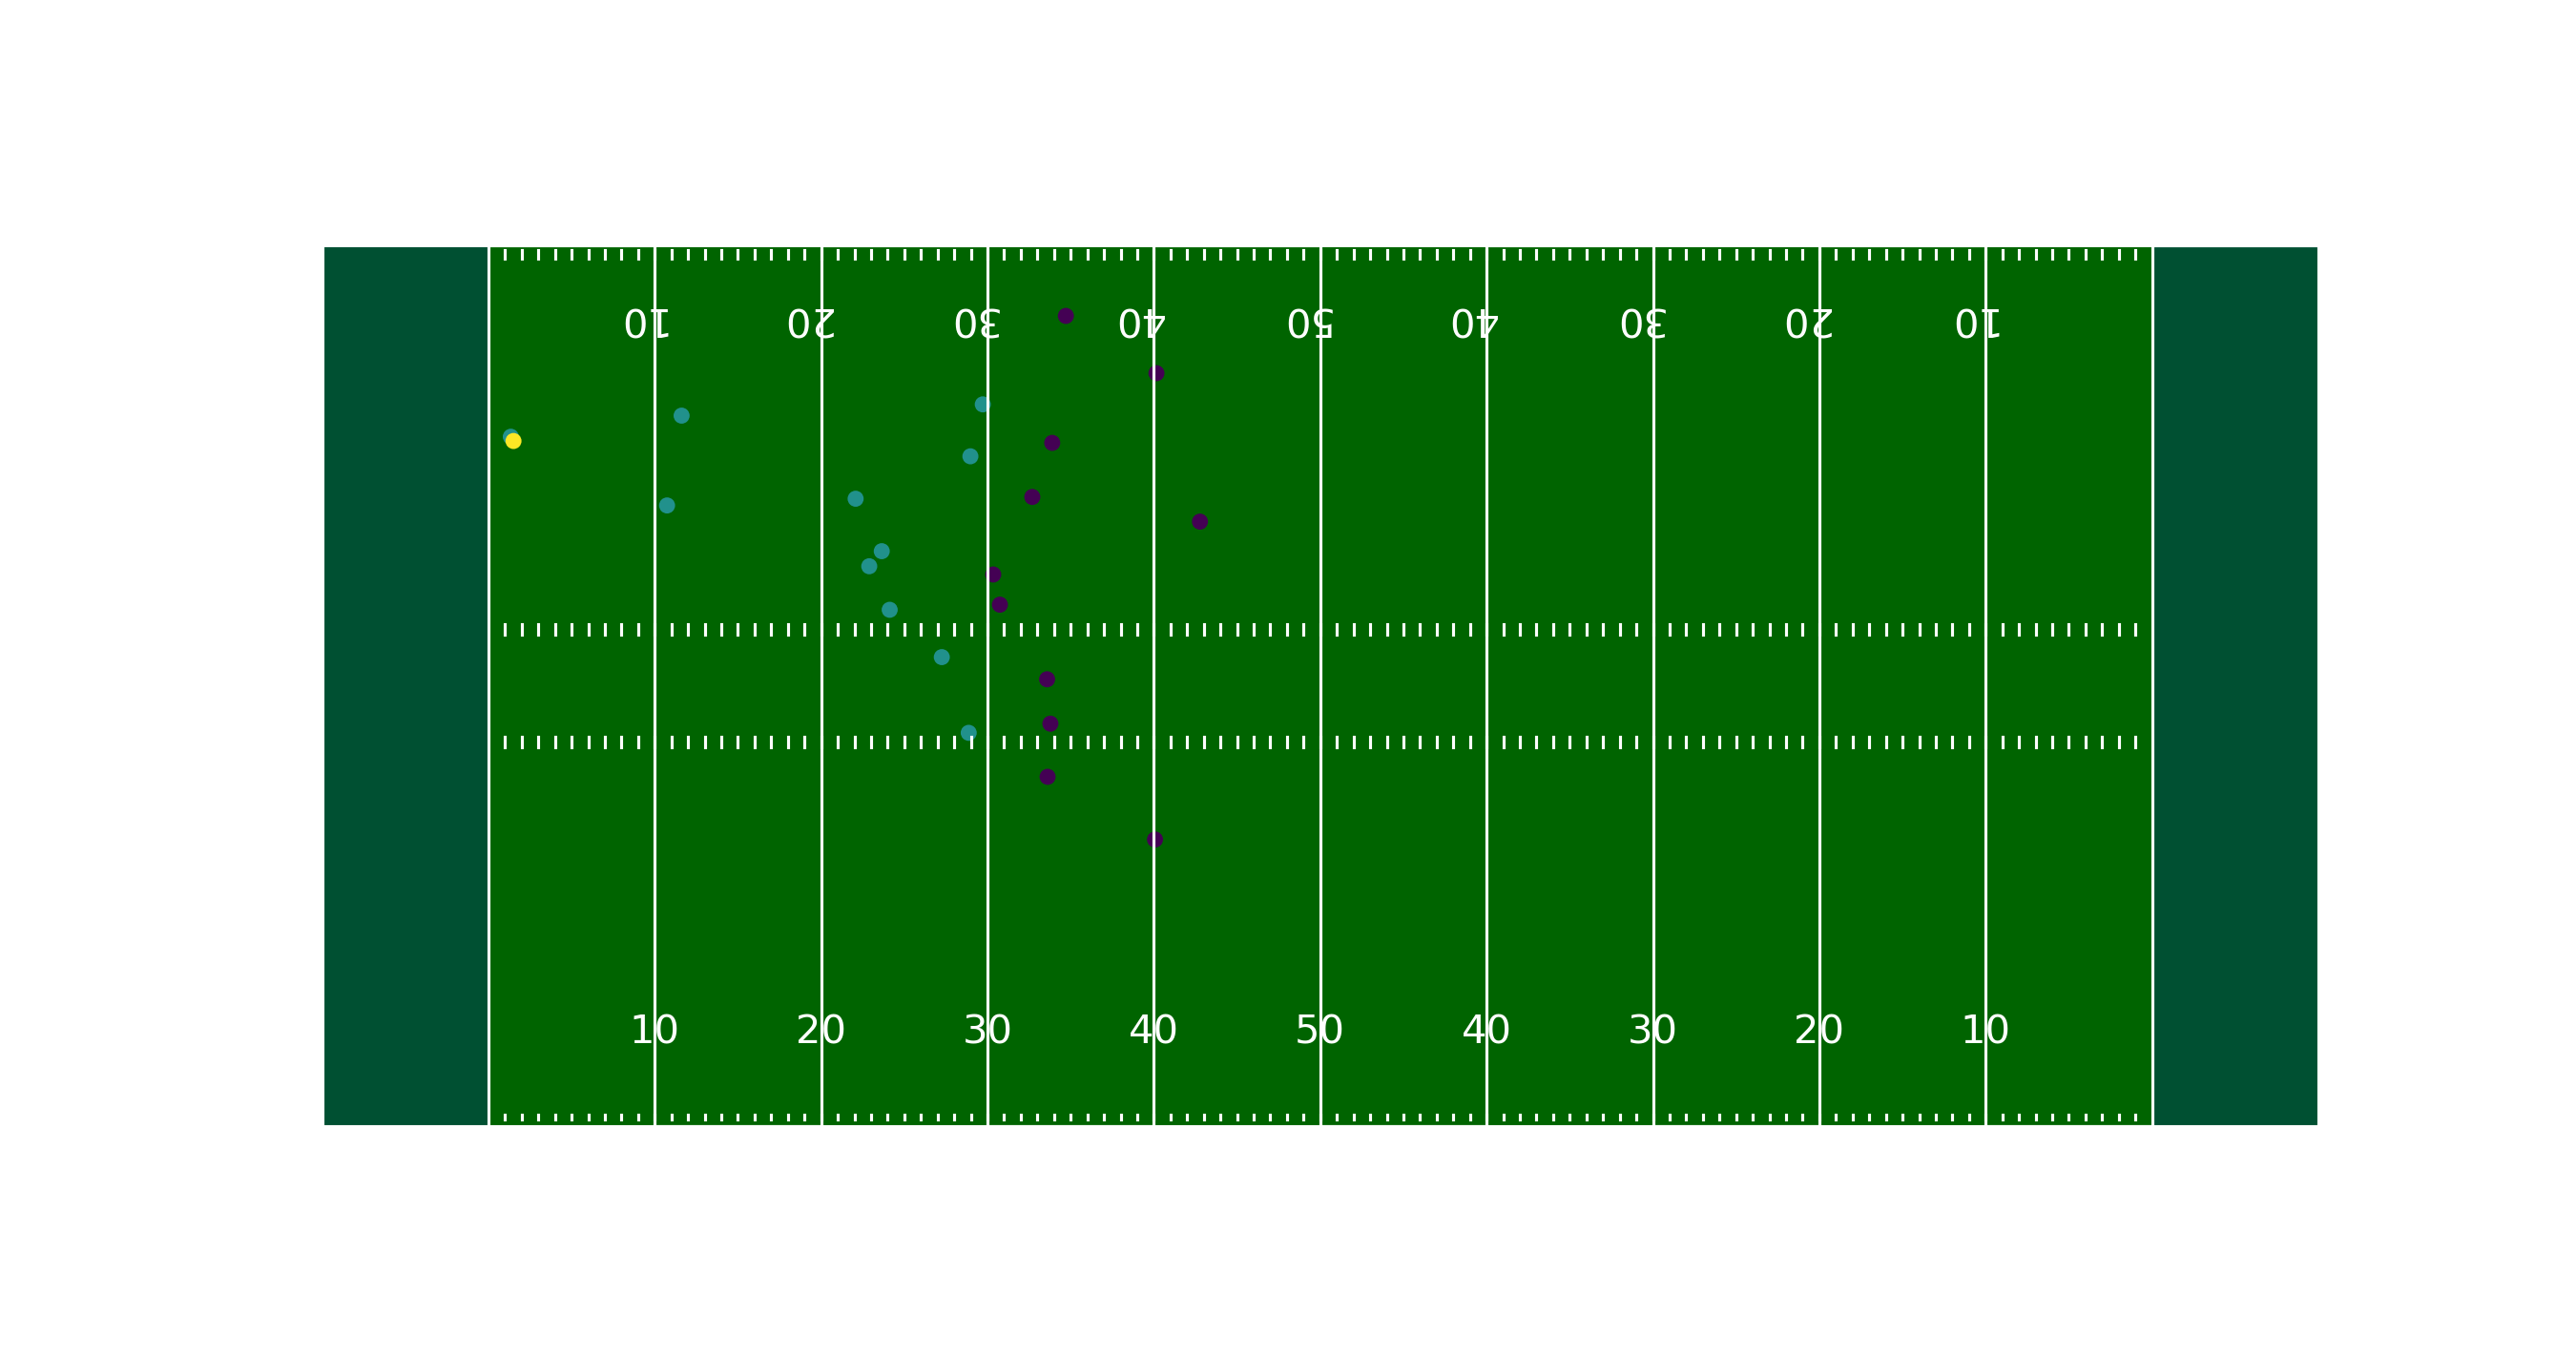

In [88]:
'''
With running state, visualize it
'''

%matplotlib notebook

def update_plot(i, tensor_state_cpu, home_away, scat):
    
    data = np.zeros((23, 2))
    data[:,0] = np.array(tensor_state_cpu[i][:,2])
    data[:,1] = np.array(tensor_state_cpu[i][:,3] + 26)
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = 20
numpoints = 10

play_to_viz = returned_plays.iloc[0,:]
home_away = get_home_away(play_to_viz, device)
tensor_state_cpu = np.array(running_state_tensor.detach().cpu())

i=0

#print(tensor_state_cpu[0][1:3,:])
#print(tensor_state_cpu[i][1:3,:])

fig, ax = create_football_field()
scat = ax.scatter(tensor_state_cpu[i][:,2],tensor_state_cpu[i][:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(tensor_state_cpu, home_away, scat))
plt.show()

<IPython.core.display.Javascript object>


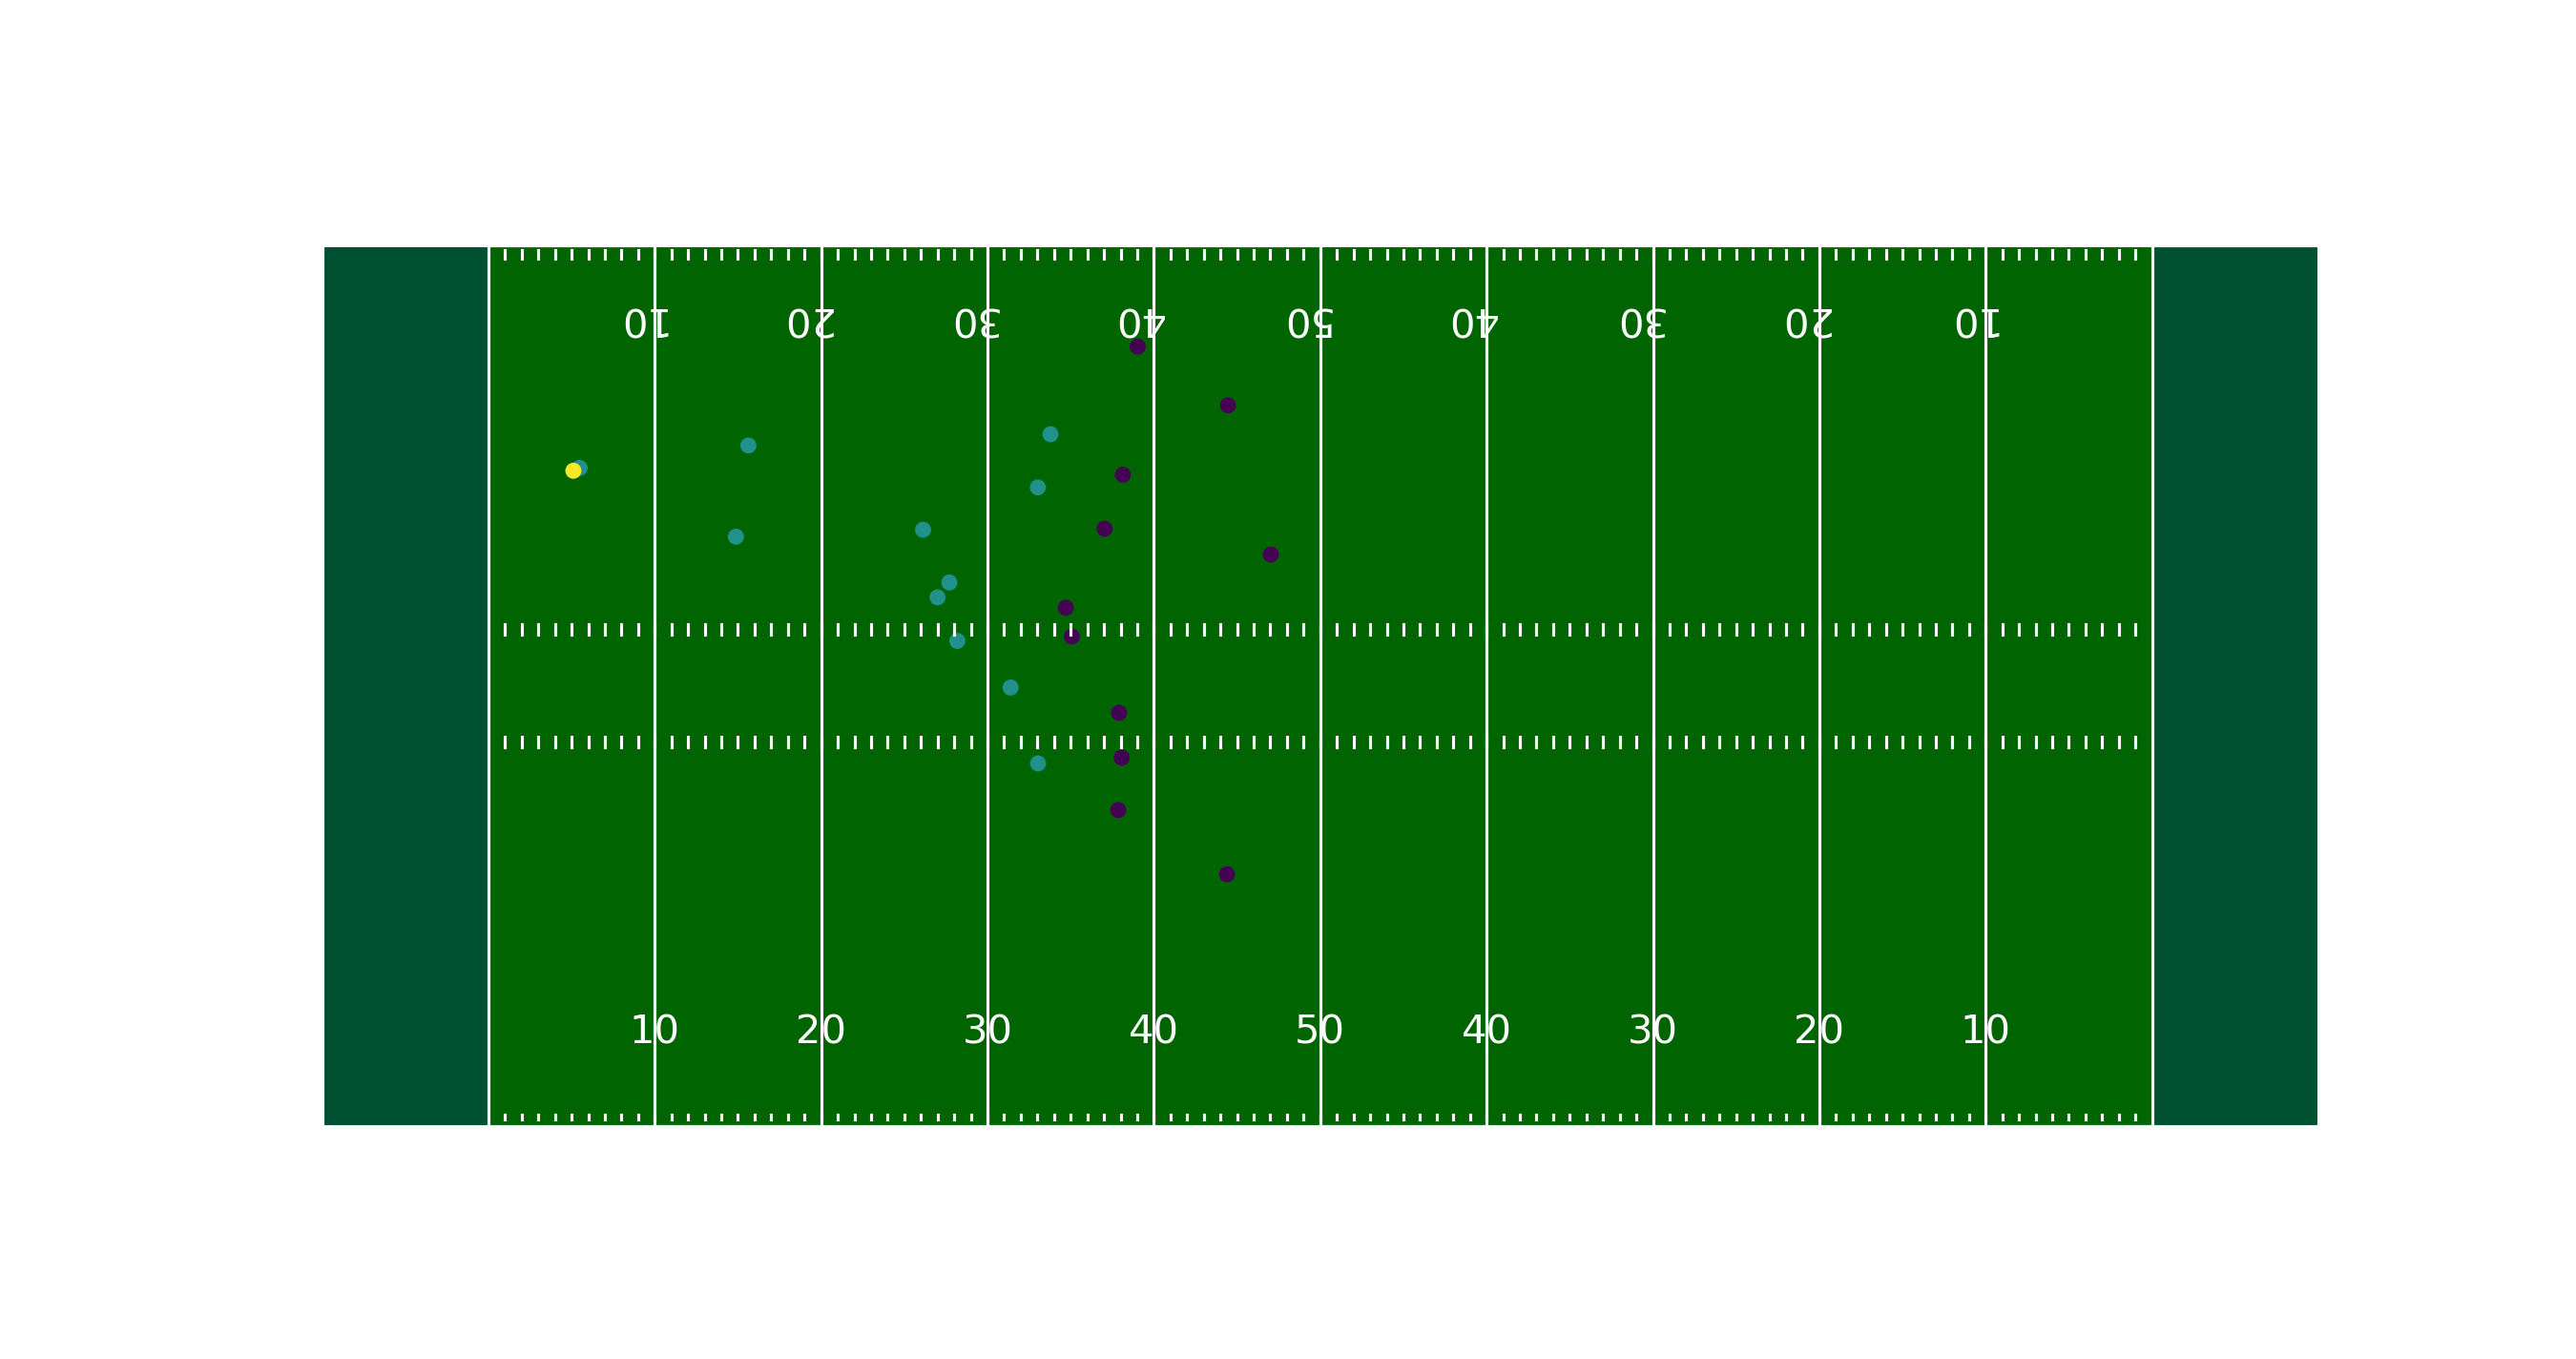

In [60]:
'''
With all actions, visualize it
'''

%matplotlib notebook

def update_plot(i, initial_state, tensor_state, home_away, scat):
    
    state = initial_state - tensor_state[i]
    
    #state = initial_state
    
    #for x in range(i):
    #    state += tensor_state[i]
    
    #scat = ax.scatter(state[:,2],state[:,3] + 26, c=home_away, s=50)
    
    #state = state.detach().cpu()
    
    data = np.zeros((23, 2))
    data[:,0] = np.array(state[:,2])
    data[:,1] = np.array(state[:,3] + 26)
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = 40
numpoints = 10

fig, ax = create_football_field()
scat = ax.scatter(first_state[:,2],first_state[:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(first_state, all_states, home_away, scat))
plt.show()

In [21]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax